# 연구과제 풀이

## 패키지 가져오기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
from sklearnex import patch_sklearn
patch_sklearn()

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

import re

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 문제 1

### (1) 위스콘신 유방암 데이터 셋

#### 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/breast-cancer-wisconsin.xlsx", index_col="id", categories=["diagnosis"], info=False)

#### 데이터 전처리

1. 종속변수 라벨링
2. 데이터 분할 + 데이터 스케일링
3. 데이터 불균형 해소 (SMOTE)

In [3]:
df1 = my_labelling(origin, 'diagnosis')

x_train, x_test, y_train, y_test = my_train_test_split(df1, 'diagnosis', scalling=True)

xdata, ydata = my_balance(x_train, y_train, method="smote")

#### SVM 분류

n_jobs를 허용하지 않음
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[교차검증 TOP5]
+----+----------+----------+-----+-------------------+
|    | kernel   |   degree |   C |   mean_test_score |
|----+----------+----------+-----+-------------------|
| 22 | rbf      |        5 |  10 |          0.977131 |
| 20 | rbf      |        4 |  10 |          0.977131 |
| 18 | rbf      |        3 |  10 |          0.977131 |
| 16 | rbf      |        2 |  10 |          0.977131 |
| 19 | poly     |        3 |  10 |          0.971852 |
+----+----------+----------+-----+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.994718 |     0.982456 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,

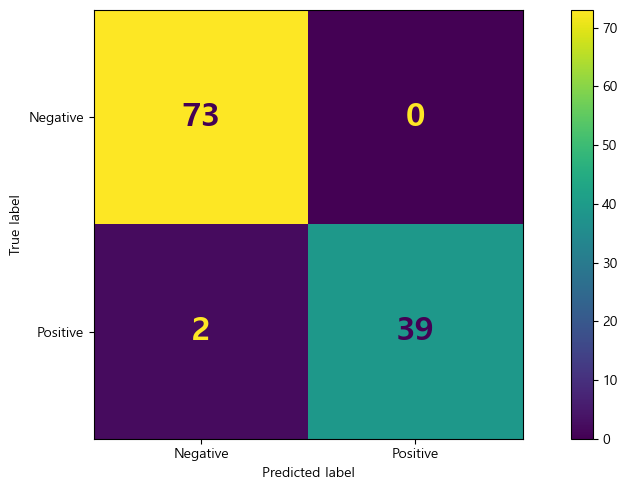


[학습곡선]


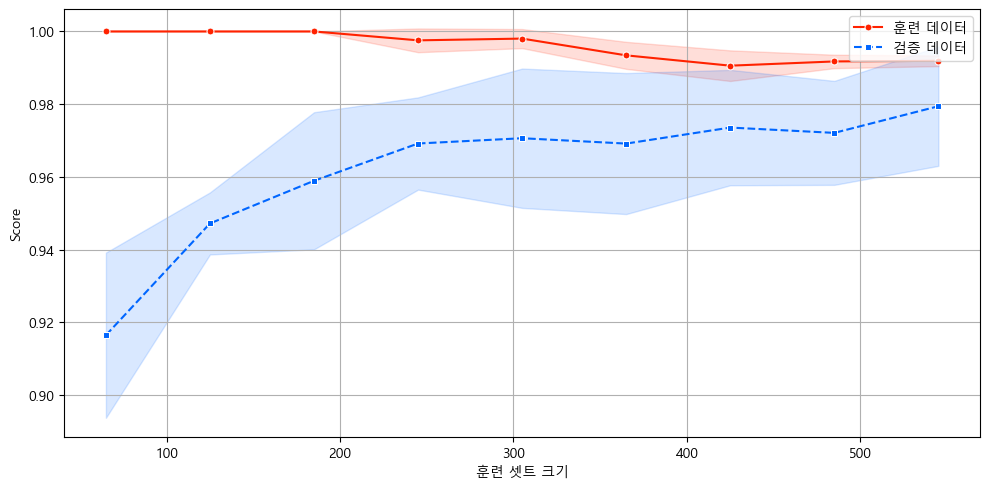

SVC(C=10, degree=2)

In [4]:
my_svc_classification(xdata, ydata, x_test, y_test)

> 로지스틱 분석을 수행한 경우 정확도 `99%`, 재현률 `97%` 였으나 KNN은 정확도 `97%`, 재현률 `95%`를 보였다.
>
> SVM의 경우에는 `98.2%`의 정확도와 `100%`의 정밀도를 보였으나 재현율은 `95.2%`에 그쳤다.
>
> 재현율을 더 중요하게 생각하는 의료 데이터의 특성상 이 데이터는 로지스틱 회귀가 더 좋은 성능을 보인다고 할 수 있다.

### (2) 타이타닉 생존률 예측

#### 데이터 가져오기

In [10]:
origin = my_read_excel("https://data.hossam.kr/edadata/titanic.xlsx", index_col='PassengerId', categories=['Survived', 'Pclass', 'Sex', 'Embarked'], info=False)

#### 데이터 전처리

1. 생존 여부에 따른 평균 나이로 결측치 치환
2. 히스토그램 구간에 따라 나이를 명목형으로 변환
3. 객실 유무에 따른 명목형 변수 생성
4. 가족 구성원 수 파생변수 생성
5. 혼자 탑승했는지에 대한 파생변수 생성
6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
8. 이름으로부터 호칭 파생변수 생성
9. 데이터 라벨링
10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
11. 불필요한 컬럼 제거

In [11]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df['Age'], bins=5)

df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

# 8. 이름으로부터 호칭 파생변수 생성
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ""

df2['Title'] = df2['Name'].apply(get_title)

df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

# 9. 데이터 라벨링
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

my_pretty_table(df4.head())

+---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------+
|   PassengerId |   Survived |   Pclass |   Sex |   Age |   Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------|
|             1 |          0 |        3 |     1 |     1 |      0 |          2 |           0 |            2 |         0 |       2 |
|             2 |          1 |        1 |     0 |     2 |      3 |          0 |           1 |            2 |         0 |       3 |
|             3 |          1 |        3 |     0 |     1 |      1 |          2 |           0 |            1 |         1 |       1 |
|             4 |          1 |        1 |     0 |     2 |      3 |          2 |           1 |            2 |         0 |       3 |
|             5 |          0 |        3 |     1 |     2 |      1 |          2 |    

#### 훈련/검증 데이터 분리

In [12]:
df4['Survived'] = df4['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 9), (262, 9), (1047,), (262,))

#### KNN 분류

n_jobs를 허용하지 않음
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[교차검증 TOP5]
+----+----------+----------+-----+-------------------+
|    | kernel   |   degree |   C |   mean_test_score |
|----+----------+----------+-----+-------------------|
| 12 | rbf      |        4 |   1 |          0.862456 |
| 14 | rbf      |        5 |   1 |          0.862456 |
|  8 | rbf      |        2 |   1 |          0.862456 |
| 10 | rbf      |        3 |   1 |          0.862456 |
| 17 | poly     |        2 |  10 |           0.85959 |
+----+----------+----------+-----+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.868195 |     0.889313 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,

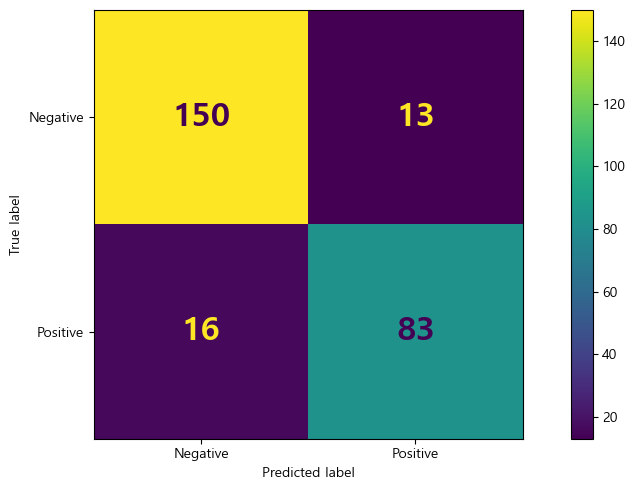

SVC(C=1, degree=2)

In [14]:
my_svc_classification(x_train, y_train, x_test, y_test, learning_curve=False)

> 로지스틱 분석의 경우 `86.6%`의 정확도와 `82.7%`의 정밀도를 보이는 반면 KNN은 `87%`의 정확도와 `84.2%`의 정밀도를 보인다.
>
> SVM의 경우 `88.9%`의 정확도와 `86.5%`의 정밀도를 보인다.
> 
> 그러므로 타이타닉 생존률 예측의 경우 SVM 분류가 가장 좋은 성능을 보인다.